<a href="https://colab.research.google.com/github/Abdul-AI-creator/Abdul-AI-creator/blob/main/Classifying_images_from_Fashion_MNIST_using_feedforward_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying images from Fashion MNIST using feedforward neural networks

**import Libraries**

In [6]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [7]:
project_name = 'Fashion-feedforward-minimal'

**Preparing Data**

In [8]:
dataset = FashionMNIST(root='/data' ,download=True ,transform=ToTensor())
test_dataset =FashionMNIST(root='/data',transform=ToTensor(),train=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.3MB/s]


Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 307kB/s]


Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.63MB/s]


Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.65MB/s]

Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



In [9]:
val_size =10000
train_size = len(dataset) - val_size
train_ds ,val_ds =random_split(dataset ,[train_size ,val_size])
len(train_ds) ,len(val_ds)

(50000, 10000)

In [10]:
batch_size =128      # no of samples in each batch

In [12]:
train_loader =DataLoader(train_ds ,batch_size ,shuffle=True ,num_workers=4 ,pin_memory=True)
val_loader = DataLoader(val_ds ,batch_size*2 ,num_workers=4 ,pin_memory=True)
test_loader =DataLoader(test_dataset ,batch_size ,num_workers=4 ,pin_memory=True)

images.shape torch.Size([128, 1, 28, 28])


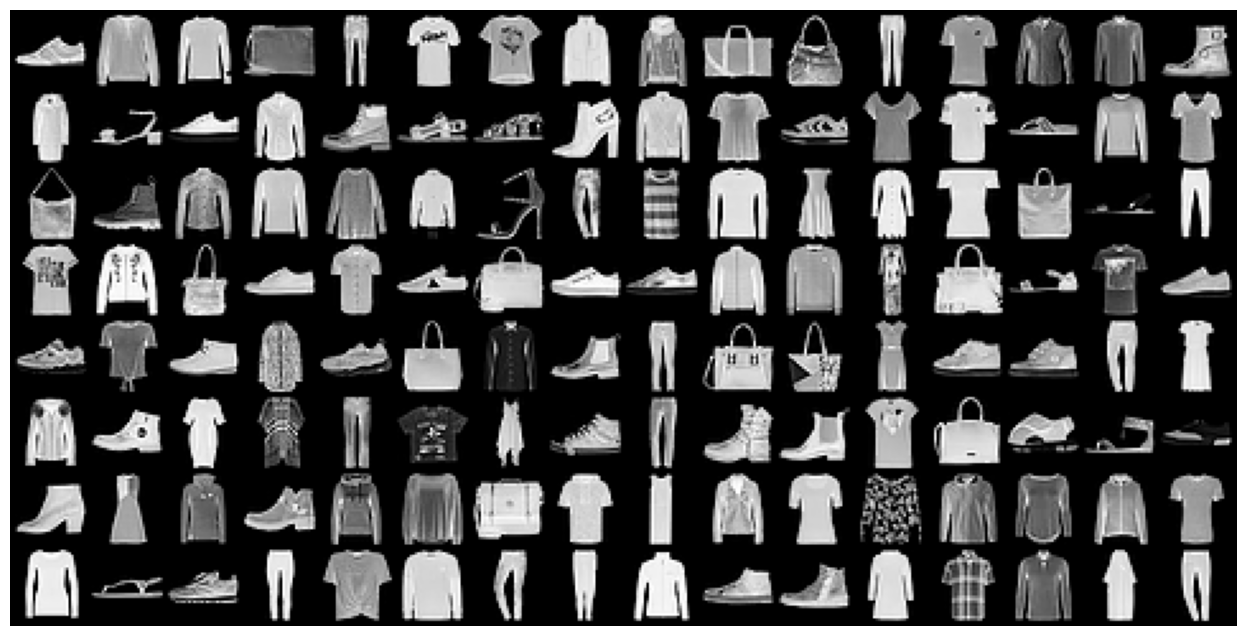

In [13]:
for images, _ in train_loader:
  print('images.shape' ,images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2 ,0)))
  break

# **Model**

In [14]:
def accuracy(outputs ,labels):
  _ ,preds =torch.max(outputs ,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))


In [15]:
class MnistModel(nn.Module):
  # Feedforward neural network with one hidden layer
  def __init__(self, in_size ,out_size):
    super().__init__()
    # hidden layer
    self.linear1 =nn.Linear(in_size, 16)
    # hidden layer 2
    self.linear2 = nn.Linear(16, 32)
    # hidden layer 3
    self.linear3 =nn.Linear(32 ,out_size)

  def forward(self ,xb):
    # Flatten the image tensor
    out =xb.view(xb.size(0) ,-1)
    # Get intermediate outputs using hidden layer 1
    out =self.linear1(out)
    # Apply activation Function
    out = F.relu(out)
    # Get intermediate outputs using hidden layer 2
    out = self.linear2(out)
    # Apply Activation Function
    out = F.relu(out)
    # GEt predicttions using output layer
    out = self.linear3(out)
    return out
  def training_step(self,batch):
    images ,labels =batch
    out=self(images)
    loss = F.cross_entropy(out ,labels)     # Generate Loss
    return loss

  def validation_step(self ,batch):
    images ,labels =batch
    out =self(images)                        # Generate Predictions
    loss =F.cross_entropy(out ,labels)       # Generate Loss
    acc = accuracy(out,labels)               # Generate Accuracy
    return {'val_loss':loss ,'val_accuracy':acc}

  def validation_epoch_end(self ,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss =torch.stack(batch_losses).mean()      # Combine losses
    batch_accs = [x['val_accuracy'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()        # Combined Accuracies
    return {'val_loss': epoch_loss.item() ,'val_accuracy': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print('Epoch [{}], val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch ,result['val_loss'] ,result['val_accuracy']))



In [16]:
torch.cuda.is_available()

False

In [17]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [18]:
device= get_default_device()
device

device(type='cpu')

In [19]:
def to_device(data, device):
  # Move tensor to chosen device
  if isinstance(data ,(list ,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device ,non_blocking =True)

In [20]:
class DeviceDataLoader():
  # Wrap DataLoader to move data to device
  def __init__(self ,dl ,device):
    self.dl =dl
    self.device=device
  def __iter__(self):
    # yield batch of data after moving it to device
    for b in self.dl:
      yield to_device(b ,self.device)

  def __len__(self):
    return len(self.dl)    # no of batches

In [21]:
train_loader = DeviceDataLoader(train_loader ,device)
val_loader = DeviceDataLoader(val_loader ,device)
test_loader = DeviceDataLoader(test_loader ,device)

# ***Training the model***

In [22]:
def evaluate(model , val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs ,lr ,model ,train_loader, val_loader ,opt_func = torch.optim.SGD):
  history =[]
  optimizer = opt_func(model.parameters() ,lr)
  for epoch in range(epochs):
    # Training Phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation Phase
    result =evaluate(model ,val_loader)
    model.epoch_end(epoch ,result)
    history.append(result)
  return history

In [23]:
input_size =784
n_classes =10

In [24]:
model =MnistModel(input_size ,out_size=n_classes)
to_device(model ,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [25]:
history = [evaluate(model ,val_loader)]
history

[{'val_loss': 2.309771776199341, 'val_accuracy': 0.09511718899011612}]

In [26]:
history += fit(5 ,0.5, model ,train_loader ,val_loader)

Epoch [0], val_loss: 1.4050, val_accuracy: 0.4371
Epoch [1], val_loss: 1.2285, val_accuracy: 0.4842
Epoch [2], val_loss: 1.2117, val_accuracy: 0.5079
Epoch [3], val_loss: 1.0192, val_accuracy: 0.5897
Epoch [4], val_loss: 0.9992, val_accuracy: 0.5684


In [27]:
history += fit(5,0.01 ,model ,train_loader ,val_loader)

Epoch [0], val_loss: 0.7365, val_accuracy: 0.7082
Epoch [1], val_loss: 0.7229, val_accuracy: 0.7212
Epoch [2], val_loss: 0.7151, val_accuracy: 0.7232
Epoch [3], val_loss: 0.7076, val_accuracy: 0.7248
Epoch [4], val_loss: 0.7020, val_accuracy: 0.7310


Text(0.5, 1.0, 'Loss Vs No. of Epochs')

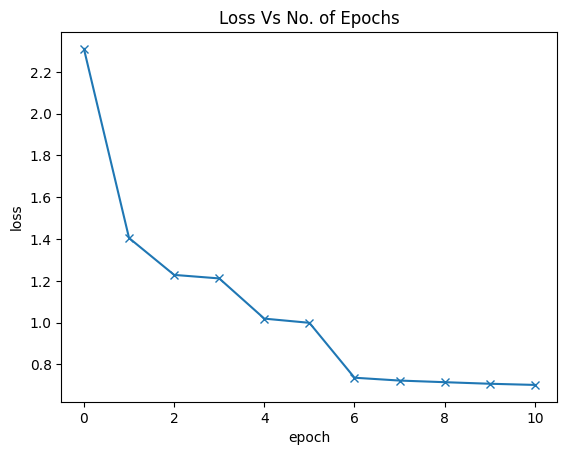

In [28]:
losses = [x['val_loss'] for x in history]
plt.plot(losses ,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss Vs No. of Epochs')

Text(0.5, 1.0, 'Accuracy vs No. of Epochs')

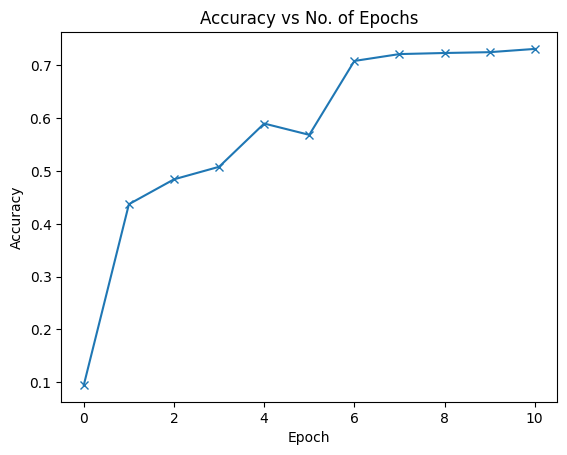

In [29]:
accuraccies = [x['val_accuracy'] for x in history]
plt.plot(accuraccies ,'-x')
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.title('Accuracy vs No. of Epochs')

# **Prediction on Samples**

In [30]:
def predict_image(img, model):
  xb =to_device(img.unsqueeze(0) ,device)
  yb = model(xb)
  _ , preds = torch.max(yb ,dim=1)
  return preds[0].item()

Label:  Ankle boot Predicted Sneaker


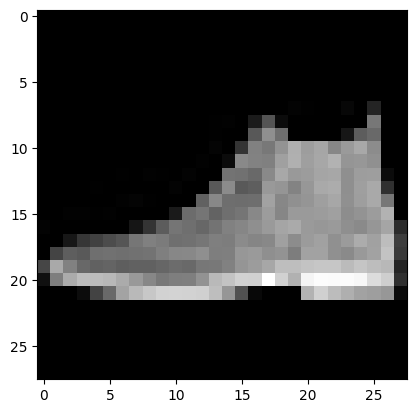

In [32]:
img ,label =test_dataset[0]
plt.imshow(img[0] ,cmap='gray')
print('Label: ', dataset.classes[label] , 'Predicted' ,dataset.classes[predict_image(img , model)])

Label:  Trouser Predicted Trouser


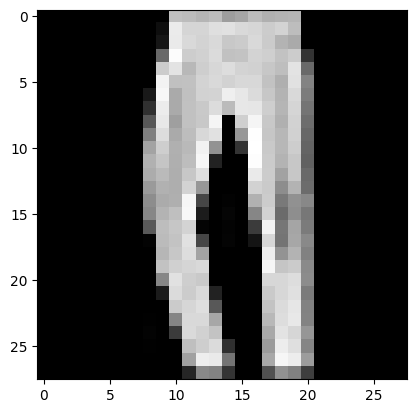

In [33]:
img , label = test_dataset[5]
plt.imshow(img[0],cmap='gray')
print('Label: ',dataset.classes[label] ,'Predicted',dataset.classes[predict_image(img , model)])

Label:  Pullover Predicted Coat


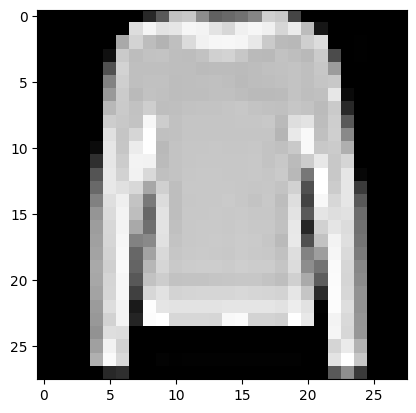

In [38]:
img , label = test_dataset[99]
plt.imshow(img[0],cmap='gray')
print('Label: ',dataset.classes[label] ,'Predicted',dataset.classes[predict_image(img , model)])

In [39]:
evaluate(model ,test_loader)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'val_loss': 0.7170437574386597, 'val_accuracy': 0.725969135761261}

In [40]:
saved_weight_fname ='Fashion-feedforward.pth'


In [41]:
torch.save(model.state_dict() ,saved_weight_fname)